# Plot of the lensing map

In [1]:
import numpy as np
import zipfile
# %matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['lines.linewidth'] = 2.0
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
import pickle as pl
from sqlalchemy import create_engine
import healpy as hp
from tqdm import tqdm
from astropy.io import ascii
import os

# CHANGE THIS PATH IN ORDER TO MATCH THE PATH OF YOUR PACKAGE
PATH_PACKAGE = '/home/miguel/Desktop/PlanckBIRD-lens'

In [2]:
Nsim = 400
Nsim_MF = 100
lmax_LB = 1000
lmax_P = 2048
L_LB = np.arange(lmax_LB + 1)
factor_L_LB = (L_LB*(L_LB+1))**2/(2*np.pi)
L_P = np.arange(lmax_P + 1)
factor_L_P = (L_P*(L_P+1))**2/(2*np.pi)
qe_list = ['TT', 'TE', 'EE', 'TB', 'EB']
qe_list_MV = qe_list + ['MV']
auto_spectra_qe = [x + y for x, y in zip(qe_list_MV, qe_list_MV)]
noise_pairs = ['TTTT', 'TTTE', 'TTEE', 'TETE', 'TEEE', 'EEEE', 'TBTB', 'TBEB', 'EBEB']
noise_pairs_2 = ['TTTE', 'TTEE', 'TEEE', 'TBEB']

pairs = []
for i in range(len(qe_list)):
    for j in range(i, len(qe_list)):
        pairs.append(qe_list[i] + qe_list[j])
pairs_no_MV = list(pairs)
pairs.append('MVMV')
# Values of fsky, w2 and w4 for Planck's 80 % mask with an apodization scale of 2 degrees.
fsky = 0.7990690867106119
w2_LB = 0.7782862278400908
w4_LB = 0.7752966348731124
w2_P = 0.6788767002202918
w4_P = 0.6758500017222131

In [3]:
cls_phiphi = ascii.read(f"{PATH_PACKAGE}/input/base_2018_plikHM_TTTEEE_lowl_lowE_lensing_cl_lensed.dat",
                     format="commented_header", header_start=10).as_array()['6:phiphi'][:lmax_P + 1]*(L_P*(L_P+1))

# MCN0 noise, MF bias and Wiener filtering

In [4]:
fd = f'{PATH_PACKAGE}/data/MCN0_bias'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
N0_LiteBIRD = []
N0_Planck = []
N0_Planck_LiteBIRD = []
MCN0_LiteBIRD = []
MCN0_Planck = []
MCN0_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # Analytical N0 bias
    N0_LiteBIRD.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    N0_Planck.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_Planck}.pkl",'rb')))
    N0_Planck_LiteBIRD.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))
    # MCN0 bias
    MCN0_LiteBIRD.append(pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    MCN0_Planck.append(pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_Planck}.pkl",'rb')))
    MCN0_Planck_LiteBIRD.append(pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))

In [5]:
fd = f'{PATH_PACKAGE}/data/N1_bias'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
N1_LiteBIRD = []
N1_Planck = []
N1_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # Analytical N1 bias
    N1_LiteBIRD.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    N1_Planck.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_Planck}.pkl",'rb')))
    N1_Planck_LiteBIRD.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))

In [6]:
fg_i = 1
WF_LiteBIRD = {qe: np.sqrt(L_LB*(L_LB+1))*cls_phiphi[:lmax_LB+1]/(cls_phiphi[:lmax_LB+1] + factor_L_LB*(MCN0_LiteBIRD[fg_i][qe+qe])+N1_LiteBIRD[i][qe+qe]) for qe in qe_list_MV}
WF_Planck = {qe: np.sqrt(L_P*(L_P+1))*cls_phiphi/(cls_phiphi + factor_L_P*(MCN0_Planck[fg_i][qe+qe]+N1_Planck[i][qe+qe])) for qe in qe_list_MV}
WF_Planck_LiteBIRD = {qe: np.sqrt(L_P*(L_P+1))*cls_phiphi/(cls_phiphi + factor_L_P*(MCN0_Planck_LiteBIRD[fg_i][qe+qe]+N1_Planck_LiteBIRD[i][qe+qe])) for qe in qe_list_MV}

/tmp/ipykernel_19602/354830765.py:2: RuntimeWarning: invalid value encountered in divide
  WF_LiteBIRD = {qe: np.sqrt(L_LB*(L_LB+1))*cls_phiphi[:lmax_LB+1]/(cls_phiphi[:lmax_LB+1] + factor_L_LB*(MCN0_LiteBIRD[fg_i][qe+qe])+N1_LiteBIRD[i][qe+qe]) for qe in qe_list_MV}
/tmp/ipykernel_19602/354830765.py:3: RuntimeWarning: invalid value encountered in divide
  WF_Planck = {qe: np.sqrt(L_P*(L_P+1))*cls_phiphi/(cls_phiphi + factor_L_P*(MCN0_Planck[fg_i][qe+qe]+N1_Planck[i][qe+qe])) for qe in qe_list_MV}
/tmp/ipykernel_19602/354830765.py:4: RuntimeWarning: invalid value encountered in divide
  WF_Planck_LiteBIRD = {qe: np.sqrt(L_P*(L_P+1))*cls_phiphi/(cls_phiphi + factor_L_P*(MCN0_Planck_LiteBIRD[fg_i][qe+qe]+N1_Planck_LiteBIRD[i][qe+qe])) for qe in qe_list_MV}


In [7]:
for qe in qe_list_MV:
    WF_LiteBIRD[qe][np.isnan(WF_LiteBIRD[qe])] = 0
    WF_Planck[qe][np.isnan(WF_Planck[qe])] = 0
    WF_Planck_LiteBIRD[qe][np.isnan(WF_Planck_LiteBIRD[qe])] = 0
    # WF_Planck[qe][:9] = 0

# Lensing map with MF correction

In [8]:
fd = f"{PATH_PACKAGE}/data/lensing_maps"

if not os.path.exists(f'{fd}/phi_0000.pkl'):
    zipfile.ZipFile(f'{fd}/lensing_maps.zip').extractall(f'{fd}')

fg = fg_arr[fg_i]
input_lensing_map = hp.alm2map(hp.almxfl(pl.load(open(f"{fd}/phi_0000.pkl",'rb')), np.sqrt(L_P*(L_P+1))), nside=2048)
lens_map_LiteBIRD_MF_corr = pl.load(open(f"{fd}/qe_MF_free_0000_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}.pkl", 'rb'))
lens_map_Planck_MF_corr = pl.load(open(f"{fd}/qe_MF_free_0000_TT_TE_EE_TB_EB_{fg}_{fname_Planck}.pkl", 'rb'))
lens_map_Planck_LiteBIRD_MF_corr = pl.load(open(f"{fd}/qe_MF_free_0000_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}.pkl", 'rb'))

lens_map_LiteBIRD_MF_corr = {qe: hp.alm2map(hp.almxfl(lens_map_LiteBIRD_MF_corr[qe], WF_LiteBIRD[qe]), nside=512) for qe in qe_list_MV}
lens_map_Planck_MF_corr = {qe: hp.alm2map(hp.almxfl(lens_map_Planck_MF_corr[qe], WF_Planck[qe]), nside=2048) for qe in qe_list_MV}
lens_map_Planck_LiteBIRD_MF_corr = {qe: hp.alm2map(hp.almxfl(lens_map_Planck_LiteBIRD_MF_corr[qe], WF_Planck_LiteBIRD[qe]), nside=2048) for qe in qe_list_MV}

/tmp/ipykernel_19602/804107454.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


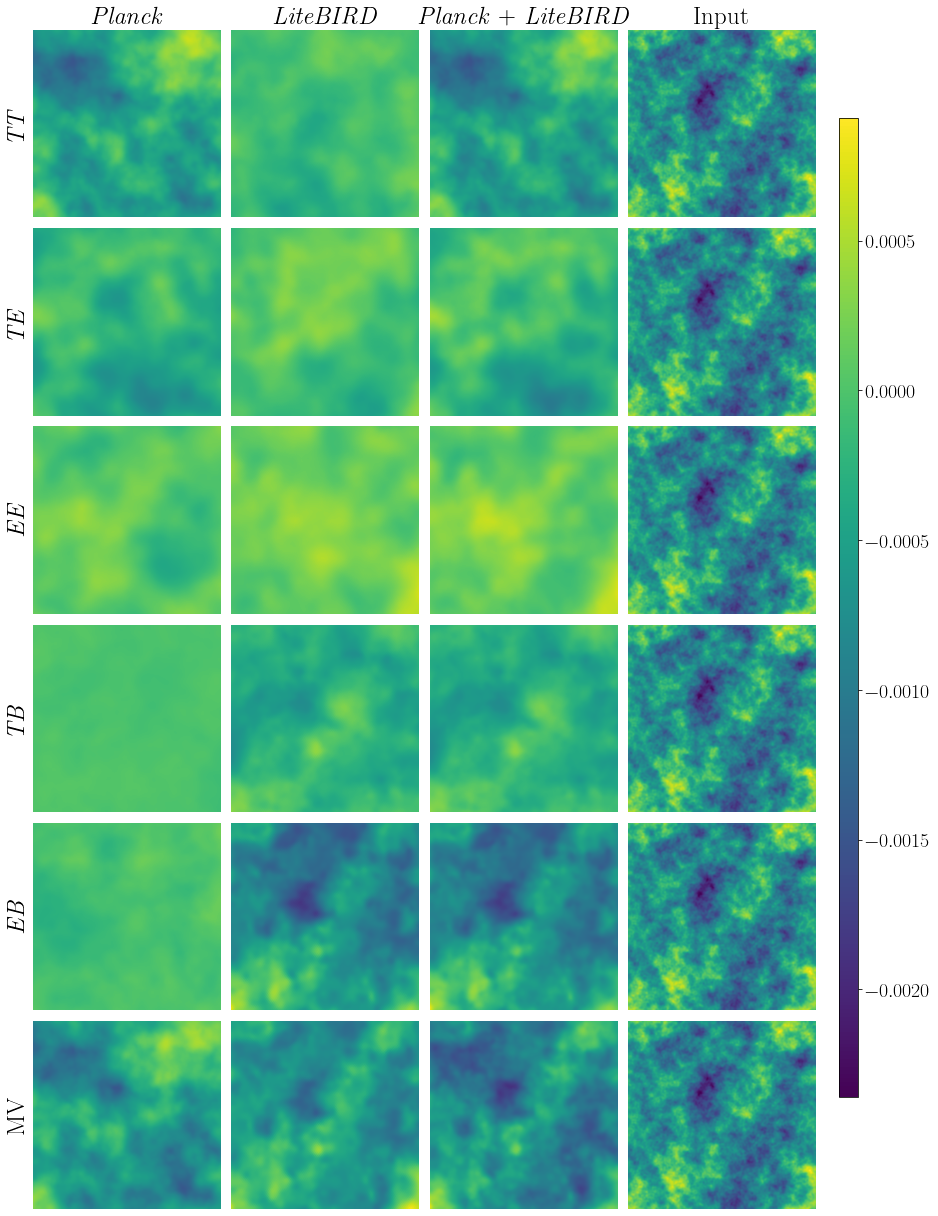

In [9]:
directory_plots = f'{PATH_PACKAGE}/notebooks/plots'
# Define min and max values for the color scale
minv = -0.00236  # Minimum value
maxv = 0.00091   # Maximum value

# Create subplots with 6 rows and 4 columns
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(13, 17))  
axs_Planck = axs[:, 0]
axs_LiteBIRD = axs[:, 1]
axs_Planck_LiteBIRD = axs[:, 2]
axs_input = axs[:, 3]

for i, qe in enumerate(qe_list_MV):
    # Planck Map
    im_planck = axs_Planck[i].imshow(hp.gnomview(lens_map_Planck_MF_corr[qe], rot=[270, -35],
                    xsize=500, unit="mK", return_projected_map=True, no_plot=True),
                        vmin=minv, vmax=maxv)
    axs_Planck[i].invert_yaxis()
    
    # LiteBIRD Map
    axs_LiteBIRD[i].imshow(hp.gnomview(lens_map_LiteBIRD_MF_corr[qe], rot=[270, -35],
                    xsize=500, unit="mK", return_projected_map=True, no_plot=True),
                          vmin=minv, vmax=maxv)
    axs_LiteBIRD[i].invert_yaxis()
    
    # Planck + LiteBIRD Map
    axs_Planck_LiteBIRD[i].imshow(hp.gnomview(lens_map_Planck_LiteBIRD_MF_corr[qe], rot=[270, -35],
                        xsize=500, unit="mK", return_projected_map=True, no_plot=True),
                                 vmin=minv, vmax=maxv)
    axs_Planck_LiteBIRD[i].invert_yaxis()
    
    # Input Map
    axs_input[i].imshow(hp.gnomview(input_lensing_map, rot=[270, -35],
                        xsize=500, unit="mK", return_projected_map=True, no_plot=True),
                                 vmin=minv, vmax=maxv)
    axs_input[i].invert_yaxis()
    
    axs_input[i].axis('off')
    axs_Planck_LiteBIRD[i].axis('off')
    axs_LiteBIRD[i].axis('off')
    if qe == 'MV':
        axs_Planck[i].set_ylabel(qe, fontsize=25)
    else:
        axs_Planck[i].set_ylabel('\\textit{'+qe+'}', fontsize=25)
    axs_Planck[i].get_xaxis().set_ticks([])
    axs_Planck[i].get_yaxis().set_ticks([])
    for spine in axs_Planck[i].spines.values():
        spine.set_visible(False)
    if i == 0:
        axs_Planck[i].set_title('\\textit{Planck}', fontsize=25)
        axs_LiteBIRD[i].set_title('\\textit{LiteBIRD}', fontsize=25)
        axs_Planck_LiteBIRD[i].set_title('\\textit{Planck} + \\textit{LiteBIRD}', fontsize=25)
        axs_input[i].set_title('Input', fontsize=25)

# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.90, 0.1, 0.02, 0.8])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(im_planck, cax=cbar_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
# cbar.set_label('Lensing-deflection map', fontsize=30)

# Adjust layout to accommodate the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.savefig(f'{directory_plots}/Lensing_patches_comparison.pdf')

# Full-sky lensing map

In [10]:
# If mask is true, it will use the binarized 80 % Planck Galactic mask.
mask = True
fd = f"{PATH_PACKAGE}/data/lensing_maps"
if not mask:
    apomask = np.ones(len(lens_map_Planck_LiteBIRD_MF_corr['MV']))
else:
    # Load the apodized mask 
    if os.path.isfile(f'{fd}/apodized_to_binary_mask_0.8.pkl'):
            apomask = pl.load(open(f'{fd}/apodized_to_binary_mask_0.8.pkl', 'rb'))
    else:
        # Need to download Planck Galactic Masks from the PLA.
        fname = f'{PATH_PACKAGE}/input_files/HFI_Mask_GalPlane-apo0_2048_R2.00.fits'
        aposcale = 2.0
        apotype = 'C1'
        mask_fsky = {20: 0, 40: 1, 60: 2, 70: 3, 80:4, 90:5, 97:6, 99:7}
        mask = hp.read_map(fname, field=4)

        # Apodized mask with the desired scale and type
        apomask = nmt.mask_apodization(mask, aposcale, apotype=apotype)
        apomask[apomask < 1.0] = 0.0
        pl.dump(apomask, open(f'{fd}/apodized_to_binary_mask_0.8.pkl', 'wb'))

<Figure size 1152x432 with 0 Axes>

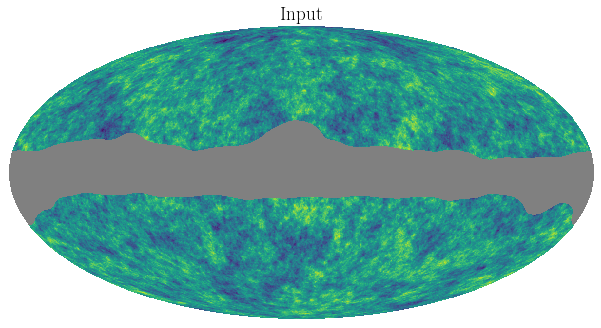

<Figure size 864x432 with 0 Axes>

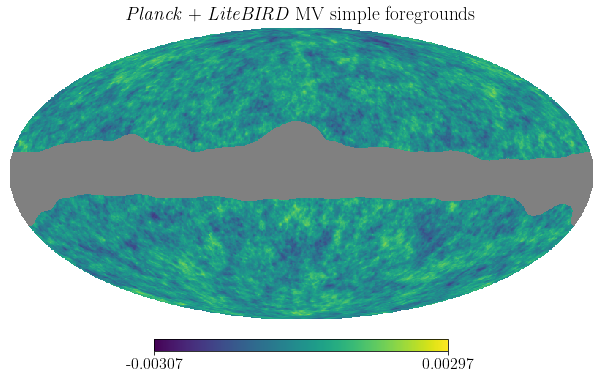

In [11]:
fontsize = 16
matplotlib.rcParams.update({'font.size':fontsize})
input_lensing_map_m = input_lensing_map.copy()
min_input = input_lensing_map_m.min()
max_input = input_lensing_map_m.max()
input_lensing_map_m[apomask == 0.0] = hp.UNSEEN 
min_input = input_lensing_map_m.min()
plt.figure(figsize=(16,6))
hp.mollview(input_lensing_map_m, cbar=False, min=-0.00307, max=0.00297, xsize=1200, title='Input')
plt.savefig(f'{directory_plots}/input_lensing_map.pdf', dpi=500)
lens_map_Planck_LiteBIRD_MF_corr_m = lens_map_Planck_LiteBIRD_MF_corr['MV'].copy()
lens_map_Planck_LiteBIRD_MF_corr_m[apomask == 0.0] = hp.UNSEEN 
plt.figure(figsize=(12,6))
# hp.mollview(lens_map_Planck_LiteBIRD_wo_MF_m, min=-0.00296166, max=0.00281739, title='Planck + LiteBIRD MV Low complexity')
hp.mollview(lens_map_Planck_LiteBIRD_MF_corr_m, min=-0.00307, max=0.00297, # unit='Lensing-deflection map',
            title='\\textit{Planck} + \\textit{LiteBIRD} MV simple foregrounds')
plt.savefig(f'{directory_plots}/lens_recon_Planck_LiteBIRD_MV_simple_fg.pdf', dpi=500)
# hp.projplot(270, -35, 'r*', markersize=10, lonlat=True)